# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# DETR
Here is a minimal implementation of DETR:

In [ ]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [ ]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /root/.cache/torch/checkpoints/detr_demo-da2a99e9.pth


# Computing predictions with DETR
The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction). In the following cells, we define the mapping from class indices to names.

In [ ]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in  [xcenter,ycenter,w,h]  format, where  [xcenter,ycenter]  is the predicted center of the bounding box, and  w,h  its width and height. Because the coordinates are relative to the image dimension and lies between  [0,1] , we convert predictions to absolute image coordinates and  [x0,y0,x1,y1]  format for visualization purposes.

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

# CODE

In [ ]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

In [ ]:
%%time
!rm -r frames/*
!mkdir frames/

rm: cannot remove 'frames/*': No such file or directory
CPU times: user 28.6 ms, sys: 18.8 ms, total: 47.4 ms
Wall time: 7.84 s


In [ ]:
video = "vid_short.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

In [ ]:
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

In [ ]:
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

24.0


In [ ]:
path_to_img="frames/30.png"

In [ ]:
img_cv = cv2.imread(path_to_img)

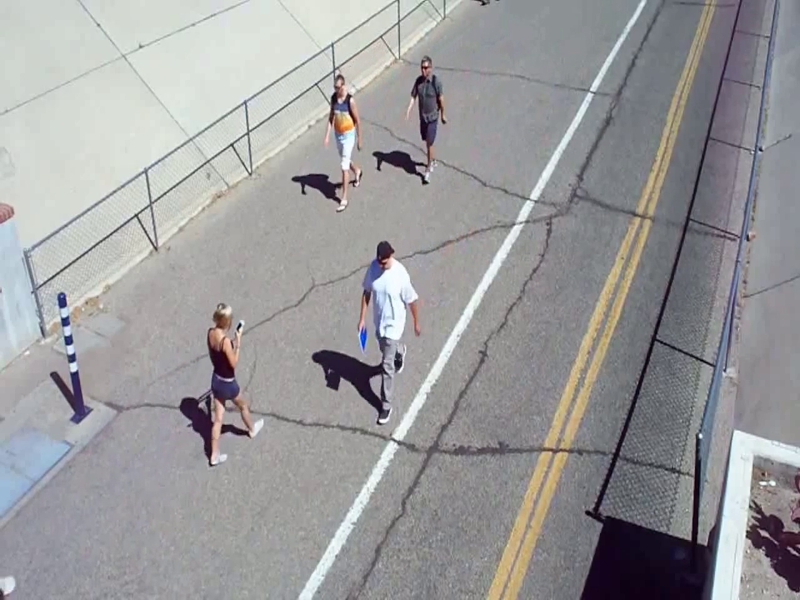

In [ ]:
path_to_img="frames/30.png"
im= Image.open(path_to_img).resize((800,600)).convert('RGB')
im

In [ ]:
scores, boxes = detect(im, detr, transform)

In [ ]:
import pandas as pd

# Using DETR
To try DETRdemo model on your own image just change the URL below.

In [ ]:
scores, boxes = detect(im, detr, transform)

In [ ]:
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

In [ ]:
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i+1)
        p2.append(j+1)
        d.append(dist[i][j])
  return p1,p2,d

In [ ]:
from PIL import Image, ImageDraw 

In [ ]:
path_to_img="frames/10.png"
im= Image.open(path_to_img).resize((800,600)).convert('RGB')

In [ ]:
scores, boxes = detect(im, detr, transform)

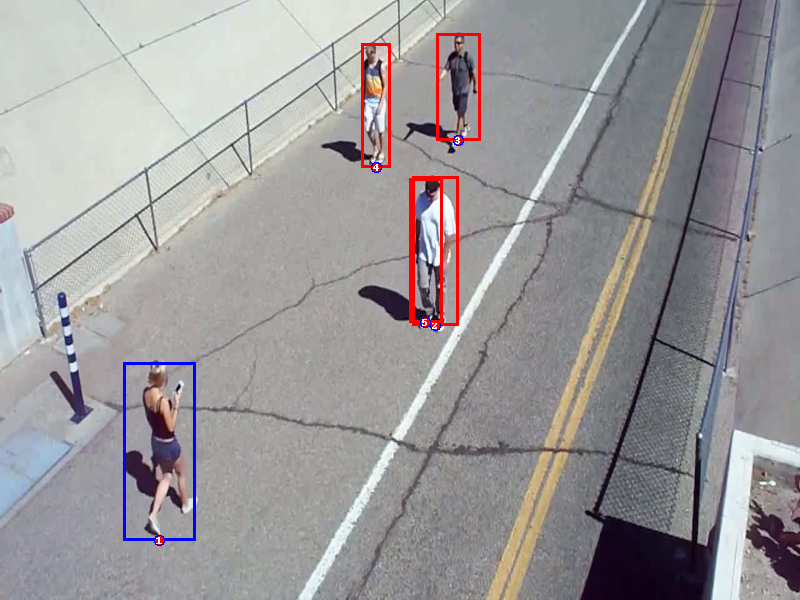

In [ ]:
im

In [ ]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [ ]:
def plot_res(pil_img, prob, boxes,names):
    count=0
    mid_points=[]  
    bounding_boxes=[]
    plt.figure(figsize=(16,10))
    draw = ImageDraw.Draw(pil_img)
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        cl = p.argmax()
        if(cl==1) and (xmax-xmin)*(ymax-ymin)>1000:
          count+=1
          
          
          draw.rectangle(((xmin, ymin), xmax, ymax), fill =None, outline ="blue",width=3)
          x_center = int((xmin+xmax)/2)
          
          y_center = int(ymax)
          r=5
          draw.ellipse((x_center-r,y_center-r,x_center+r,y_center+r), fill = 'red', outline ='blue')

          center = (x_center, y_center)
          mid_points.append(center)
          #font = ImageFont.truetype("arial.ttf", 18)

          draw.text((x_center-r+2, y_center-r), str(count),size=38,fontsize=20)
          bounding_boxes.append([xmin, ymin, xmax, ymax])
    dist= compute_distance(mid_points,count)
    thresh=100
    p1,p2,d=find_closest(dist,count,thresh)
    df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
    risky = np.unique(p1+p2)
    for i in risky:
      xmin, ymin, xmax, ymax=bounding_boxes[i-1]
      draw.rectangle(((xmin, ymin), xmax, ymax), fill =None, outline ="red",width=3)
      x_center,y_center=mid_points[i-1]
      draw.ellipse((x_center-r,y_center-r,x_center+r,y_center+r), fill = 'red', outline ='blue')
      draw.text((x_center-r+2, y_center-r), str(i),size=38,fontsize=20)

    pil_img.save("detected/"+str(names))
    
plot_res(im, scores, boxes,"bitch.png")

<Figure size 1152x720 with 0 Axes>

# another way around


   p1  p2       dist
0   1   3  81.024688


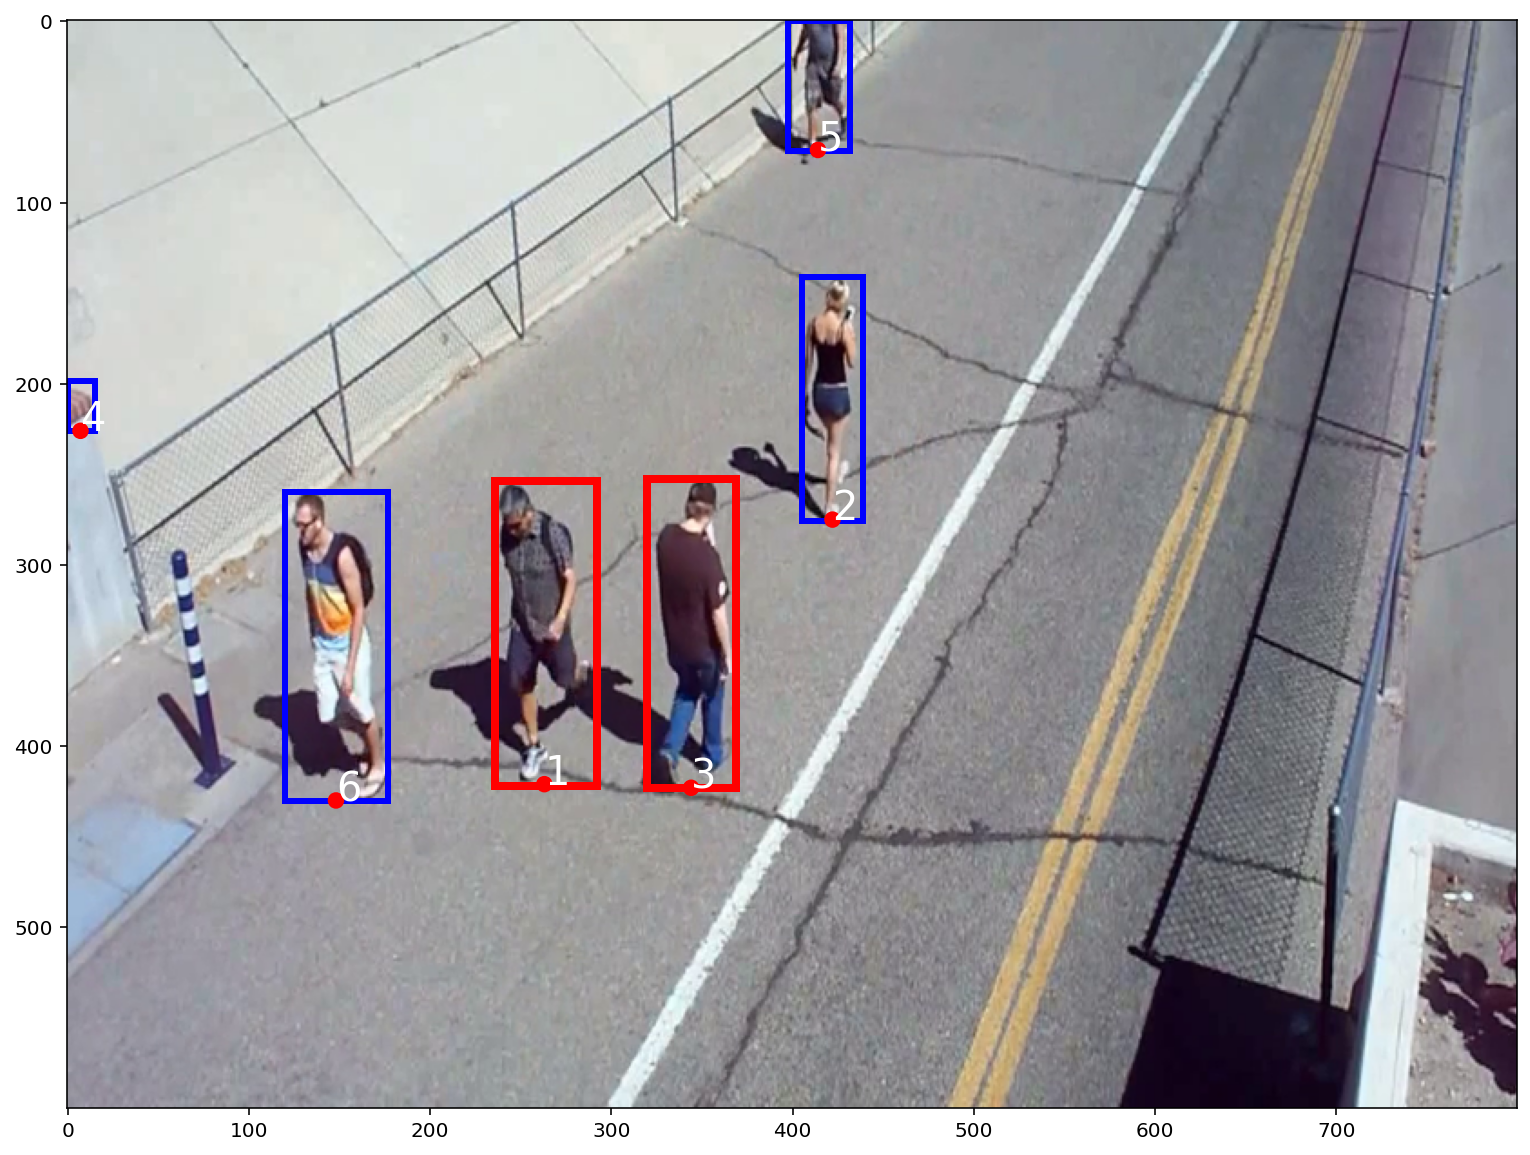

In [ ]:
def plot_results(pil_img, prob, boxes):
    count=0
    mid_points=[]
    bounding_boxes=[]
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        cl = p.argmax()
        if(cl==1):
          
          count+=1
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color='blue', linewidth=3))
          bounding_boxes.append([xmin, ymin, xmax, ymax])
          x_center = int((xmin+xmax)/2)
          y_center = int(ymax)

          center = (x_center, y_center)
          mid_points.append(center)
          ax.add_patch(plt.Circle((center),4, color='red'))
          
          #text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(x_center, y_center, count, style='normal',color='white', fontsize=20)
    dist= compute_distance(mid_points,count)
    thresh=100
    p1,p2,d=find_closest(dist,count,thresh)
    df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
    print(df)
    risky = np.unique(p1+p2)
    for i in risky:
      xmin, ymin, xmax, ymax=bounding_boxes[i-1]
      ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color='red', linewidth=4))


    #plt.axis('off')
    #plt.show()
    
#plot_results(im, scores, boxes)

# Processing image

In [ ]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
!rm -r detected/*
!mkdir detected/

rm: cannot remove 'detected/*': No such file or directory


In [ ]:
print(names)

['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png'

In [ ]:
for i in names:
  print(i)
  path_to_img="frames/"+i
  im= Image.open(path_to_img).resize((800,600)).convert('RGB')
  scores, boxes = detect(im, detr, transform)
  plot_res(im, scores, boxes,i)





In [ ]:
import os
import re

In [ ]:
frames = os.listdir('detected/')


In [ ]:
print(frames)

['36.png', '54.png', '189.png', '301.png', '370.png', '160.png', '399.png', '208.png', '378.png', '454.png', '182.png', '459.png', '387.png', '114.png', '190.png', '310.png', '13.png', '48.png', '98.png', '213.png', '472.png', '46.png', '158.png', '337.png', '129.png', '127.png', '75.png', '188.png', '3.png', '185.png', '195.png', '280.png', '265.png', '100.png', '440.png', '47.png', '108.png', '167.png', '468.png', '219.png', '136.png', '173.png', '154.png', '27.png', '384.png', '363.png', '449.png', '394.png', '96.png', '259.png', '338.png', '299.png', '99.png', '130.png', '184.png', '362.png', '476.png', '90.png', '291.png', '132.png', '423.png', '359.png', '227.png', '266.png', '365.png', '58.png', '125.png', '53.png', '186.png', '313.png', '119.png', '148.png', '42.png', '441.png', '97.png', '285.png', '409.png', '425.png', '419.png', '429.png', '289.png', '35.png', '233.png', '163.png', '104.png', '128.png', '358.png', '457.png', '372.png', '434.png', '371.png', '336.png', '257.p

In [ ]:
frame_array=[]
for i in names:
  path_to_img="detected/"+i
  print(path_to_img)
  frame_array.append(path_to_img)



In [ ]:
import moviepy.video.io.ImageSequenceClip

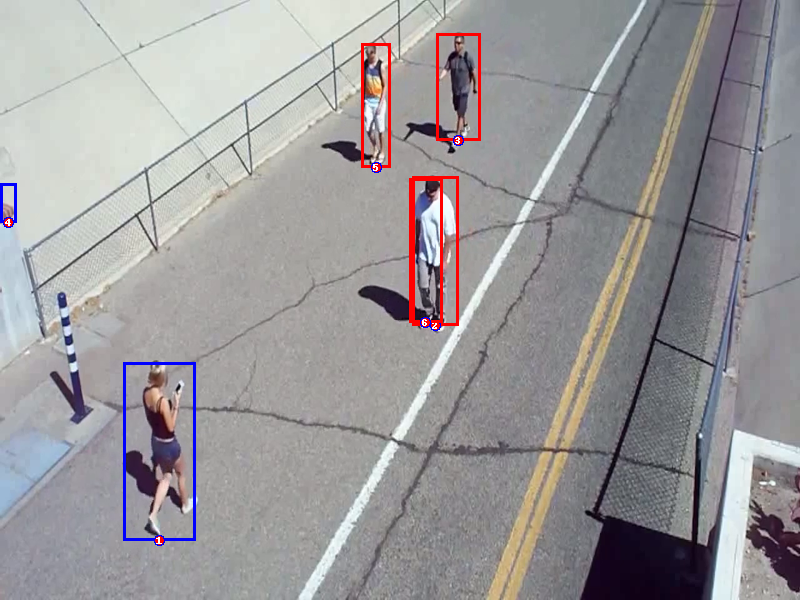

In [ ]:
for i in frame_array[10:]:
  im= Image.open(i).resize((800,600)).convert('RGB')
  break
im

In [ ]:
path_to_img="detected/478.png"
im= Image.open(path_to_img).resize((800,600)).convert('RGB')

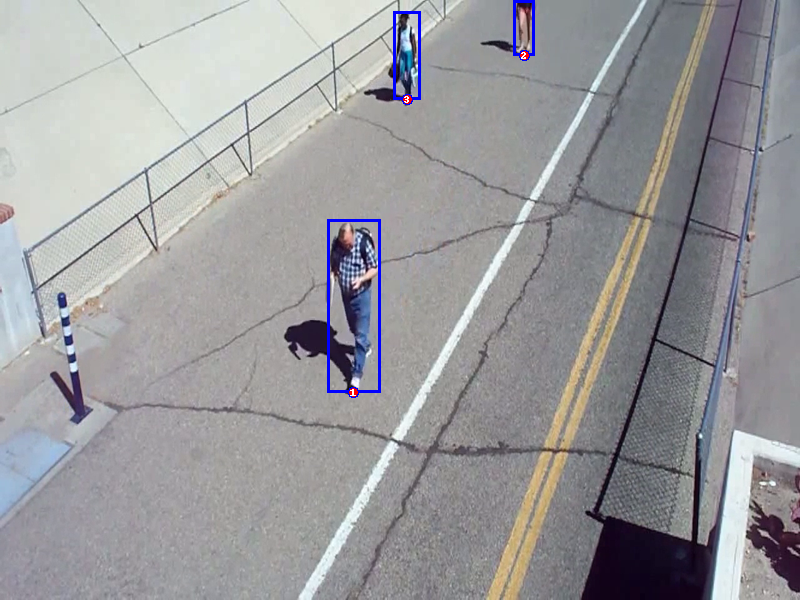

In [ ]:
im

In [ ]:
image_folder='detected'
fps=8

# = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]


In [ ]:
ls

detected/  frames/  sample_data/  vid_short.mp4


In [ ]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frame_array, fps=36)
clip.write_videofile('pp.mp4')

[MoviePy] >>>> Building video pp.mp4
[MoviePy] Writing video pp.mp4


100%|██████████| 480/480 [00:21<00:00, 22.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: pp.mp4 

